# 제주 신용카드 데이콘 예측

- public score : lb 1.89511
- 2019년 데이터는 2020년 데이터에 많은 영향을 주지 않을거라고 생각하고 2020년 데이터만 활용함.
- "CARD_SIDO_NM","STD_CLSS_NM"별로 "FLC"에 따라 2020년 2월 "AMT"값과 2020년 3월 "AMT"값의 차이를 토대로 2020년 3월 데이터에 차이를 적용해 값을 예측
- "FLC" feature를 사용한 이유: 날짜별 총 이용금액이 날짜별, FLC에 따른 총 이용금액 모양과 매우 비슷하다. 따라서 FLC별로 예측하면 도움이 될것이라고 생각했다.
- 따라서 2월, 3월의 차이에 따라서 4월의 "AMT"를 예측하게 된다. 하지만 2019년 3월, 4월 데이터를 확인하면 시도별 ,업종별, 가구 별로 다르긴 하지만 대부분 이용금액이 낮아지는 경향이 있다. 이 경향을 추가하는 방법을 고려해보는 것도 괜찮아 보인다. 
- 원래 2월에서 3월로 갈때 매출이 떨어지는 경향이 있는 업종이 있다는 것을 생각하지 못함.
- 2019년 데이터를 어느정도 적용하면 예측값이 어느정도 올라가지 않을까 생각된다.

참고1:https://dacon.io/competitions/official/235615/codeshare/1231?page=1&dtype=recent&ptype=pub

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Han Santteut Dotum'   #한글 사용 가능

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 50
plt.style.use('ggplot')

In [2]:
data = pd.read_csv('C:/Users/chowonjae/Desktop/jeju_data_ver1/201901-202003.csv')
data["DATE"] = pd.to_datetime(data["REG_YYMM"],format='%Y%m')

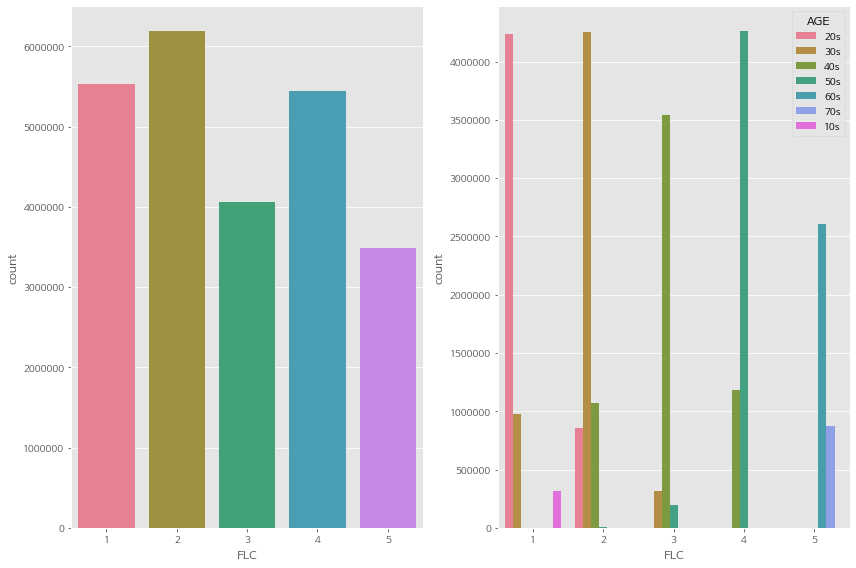

In [3]:
#세대 주기

fig, ax = plt.subplots(1,2, figsize= (12, 8))
sns.countplot("FLC", data= data, palette = "husl", ax = ax[0])
sns.countplot("FLC", hue = "AGE", data = data, palette = "husl", ax = ax[1])
plt.tight_layout()
plt.show()
#(1: 1인가구, 2: 영유아자녀가구, 3: 중고생자녀가구, 4: 성인자녀가구, 5: 노년가구)

In [4]:
# 가구별로 AMT계산

df_flc = data.groupby("FLC")["AMT"].sum().to_frame().style.background_gradient(cmap = "summer_r")
df_flc

# 성인 자녀 가구가 가장 많이 사용(가장 돈을 많이 쓰는 연령대인 50대가 가장 많이 포함되어 있기 때문인것 같다.)

,AMT
FLC,
1,7371507278072
2,12619055902225
3,11538603588734
4,17864707502682
5,10902152777293


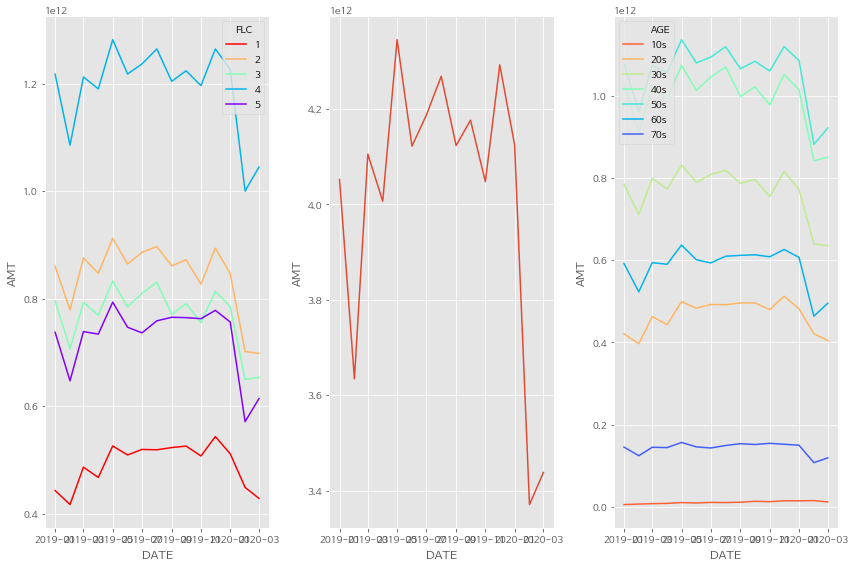

In [5]:
#가구별로 날짜에 따른 AMT 계산

fig, ax = plt.subplots(1,3, figsize = (12,8))
df_flc_reg = data.groupby(["DATE", "FLC"])["AMT"].sum().to_frame().rename(columns = {0 : "AMT"})
df_flc_reg = df_flc_reg.reset_index()
sns.lineplot(x= "DATE", y = "AMT", hue = "FLC", data = df_flc_reg, palette = 'rainbow_r', ax = ax[0])
ax[0].legend(title = "FLC", labels = [1,2,3,4,5])
df_amt = data.groupby("DATE")["AMT"].sum().to_frame().rename(columns = {0 : "AMT"}).reset_index()
sns.lineplot(x = "DATE", y = "AMT", data = df_amt, ax= ax[1])
df_amt_age = data.groupby(["DATE", "AGE"])["AMT"].sum().to_frame().rename(columns = {0 : "AMT"}).reset_index()
sns.lineplot(x = "DATE", y = "AMT", hue = "AGE", data = df_amt_age, palette = 'rainbow_r', ax = ax[2])
ax[2].legend(loc = "upper left")
plt.tight_layout()
plt.show()
## 성안자녀가구의 이용금액의 추세를 예측하는 것도 좋은 방법일듯.

In [6]:
df_reg = data[(data["DATE"] == "2020-02") | (data["DATE"] == "2020-03")]
df_reg = df_reg.groupby(["DATE", "CARD_SIDO_NM", "STD_CLSS_NM", "FLC"])["AMT"].sum().to_frame().reset_index()
df_reg = df_reg.set_index(["CARD_SIDO_NM", "STD_CLSS_NM", "FLC"])
FLCs = data.FLC.unique()
for index in df_reg.index:
            try:
                tmp = df_reg.loc[index]
                mar = float(tmp[tmp["DATE"] == "2020-03"].AMT.values)
                feb = float(tmp[tmp["DATE"] == "2020-02"].AMT.values)
                if mar > feb:    
                    df_reg.loc[index, "Diff"] = (mar - feb) * (feb / mar)   ## 2020년 2월보다 3월의 매출이 증가한 경우
                                                                            ## 4월에도 증가할 것이라고 예측
                else:
                    df_reg.loc[index, "Diff"] = (mar - feb) * (mar / feb)   ## 2020년 2월보다 3월의 매출 감소한 경우
                                                                            ## 4월에도 감소할 것이라고 예측
            except:
                continue

In [7]:
df_reg["FINAL_AMT"] = df_reg["AMT"] + df_reg["Diff"]  ##3월 데이터에 위에서 구한 Diff를 적용함.
df_reg = df_reg[df_reg["DATE"] == "2020-03"]
df_reg = df_reg.groupby(["CARD_SIDO_NM", "STD_CLSS_NM"])["FINAL_AMT"].sum().to_frame()
df_reg = df_reg.reset_index()
df_reg.head()

,CARD_SIDO_NM,STD_CLSS_NM,FINAL_AMT
0,강원,건강보조식품 소매업,1.110039e+08
1,강원,골프장 운영업,3.541473e+09
2,강원,과실 및 채소 소매업,1.103793e+09
3,강원,관광 민예품 및 선물용품 소매업,1.212750e+07
4,강원,그외 기타 스포츠시설 운영업,1.816159e+06


In [8]:
df_reg[df_reg["FINAL_AMT"] < 0]  ##FINAL_AMT가 0보다 낮은 경우는 없다.

,CARD_SIDO_NM,STD_CLSS_NM,FINAL_AMT


In [9]:
#submission 파일 생성

submission = pd.read_csv('C:/Users/chowonjae/Desktop/jeju_data_ver1/submission.csv', index_col=0)
submission = submission.loc[submission['REG_YYMM']==202004]
submission = submission[['CARD_SIDO_NM', 'STD_CLSS_NM']]
submission = submission.merge(df_reg, left_on=['CARD_SIDO_NM', 'STD_CLSS_NM'], right_on=['CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
submission = submission.fillna(0)
AMT = list(submission['FINAL_AMT'])*2

submission = pd.read_csv('C:/Users/chowonjae/Desktop/jeju_data_ver1/submission.csv', index_col=0)
submission['AMT'] = AMT
submission.to_csv('credit_submission1.csv', encoding='utf-8-sig')
submission.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
id,,,,
0,202004,강원,건강보조식품 소매업,1.110039e+08
1,202004,강원,골프장 운영업,3.541473e+09
2,202004,강원,과실 및 채소 소매업,1.103793e+09
3,202004,강원,관광 민예품 및 선물용품 소매업,1.212750e+07
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,0.000000e+00
